This booklet walks you through our Book Recommender System — a project that recommends books to users based on their ratings. We started with simple baselines (popularity, item-based nearest neighbors), built a matrix factorization model, evaluated recommendations using ranking metrics, and explored how to serve recommendations in a real app. It’s a mix of data science, software engineering, and user-centered thinking.
Flip through to see how the data was cleaned, models were trained, and why some recommendations work (or don’t). If you like books, math, or building things that help people discover new reads, you’re in the right place.

In [1]:
import numpy as np
import pandas as pd


In [2]:
books = pd.read_csv('Books.csv')
users = pd.read_csv('Users.csv')
ratings = pd.read_csv('Ratings.csv')

/tmp/ipython-input-1748781244.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books = pd.read_csv('Books.csv')


In [3]:
books.head(5)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [4]:
users.head(5)

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [5]:
ratings.head(5)

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [6]:
print(books.shape)
print(users.shape)
print(ratings.shape)

(271360, 8)
(278858, 3)
(1149780, 3)


In [7]:
books.isnull().sum()

,0
ISBN,0
Book-Title,0
Book-Author,2
Year-Of-Publication,0
Publisher,2
Image-URL-S,0
Image-URL-M,0
Image-URL-L,3


In [8]:
users.isnull().sum()

,0
User-ID,0
Location,0
Age,110762


In [9]:
ratings.isnull().sum()

,0
User-ID,0
ISBN,0
Book-Rating,0


In [10]:
books.duplicated().sum()

np.int64(0)

In [11]:
users.duplicated().sum()

np.int64(0)

In [12]:
ratings.duplicated().sum()

np.int64(0)

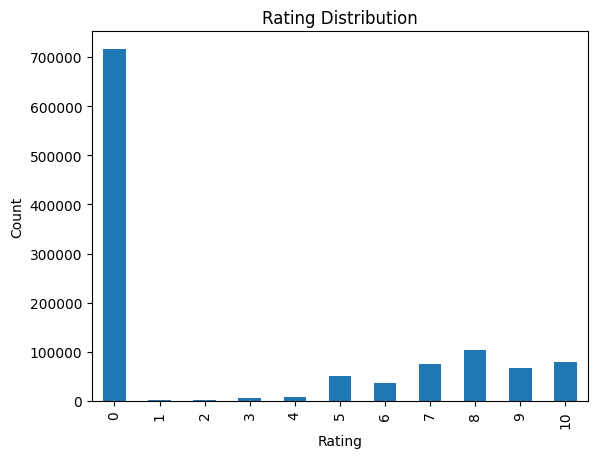

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

ratings = pd.read_csv("Ratings.csv")

ratings['Book-Rating'].value_counts().sort_index().plot(kind='bar')
plt.title("Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()


**Popularity Based Recommender System**

In [14]:
ratings_with_name = ratings.merge(books,on='ISBN')

In [15]:
num_rating_df = ratings_with_name.groupby('Book-Title').count()['Book-Rating'].reset_index()
num_rating_df.rename(columns={'Book-Rating':'num_ratings'},inplace=True)
num_rating_df

,Book-Title,num_ratings
0,A Light in the Storm: The Civil War Diary of ...,4
1,Always Have Popsicles,1
2,Apple Magic (The Collector's series),1
3,"Ask Lily (Young Women of Faith: Lily Series, ...",1
4,Beyond IBM: Leadership Marketing and Finance ...,1
...,...,...
241066,Ã?Â?lpiraten.,2
241067,Ã?Â?rger mit Produkt X. Roman.,4
241068,Ã?Â?sterlich leben.,1
241069,Ã?Â?stlich der Berge.,3


In [16]:
ratings_with_name['Book-Rating'].unique()[:20]



array([ 0,  5,  3,  6,  7,  9,  8, 10,  1,  4,  2])

In [17]:
ratings_with_name['Book-Rating'] = pd.to_numeric(ratings_with_name['Book-Rating'], errors='coerce')

In [18]:
ratings_with_name['Book-Rating'] = pd.to_numeric(
    ratings_with_name['Book-Rating'], errors='coerce'
)
ratings_with_name = ratings_with_name.dropna(subset=['Book-Rating'])


In [19]:
avg_rating_df = (
    ratings_with_name.groupby('Book-Title')['Book-Rating']
    .mean()
    .reset_index(name='avg_ratings')
)


In [20]:
avg_rating_df

,Book-Title,avg_ratings
0,A Light in the Storm: The Civil War Diary of ...,2.250000
1,Always Have Popsicles,0.000000
2,Apple Magic (The Collector's series),0.000000
3,"Ask Lily (Young Women of Faith: Lily Series, ...",8.000000
4,Beyond IBM: Leadership Marketing and Finance ...,0.000000
...,...,...
241066,Ã?Â?lpiraten.,0.000000
241067,Ã?Â?rger mit Produkt X. Roman.,5.250000
241068,Ã?Â?sterlich leben.,7.000000
241069,Ã?Â?stlich der Berge.,2.666667


In [22]:
popular_df = num_rating_df.merge(avg_rating_df,on='Book-Title')
popular_df

,Book-Title,num_ratings,avg_ratings
0,A Light in the Storm: The Civil War Diary of ...,4,2.250000
1,Always Have Popsicles,1,0.000000
2,Apple Magic (The Collector's series),1,0.000000
3,"Ask Lily (Young Women of Faith: Lily Series, ...",1,8.000000
4,Beyond IBM: Leadership Marketing and Finance ...,1,0.000000
...,...,...,...
241066,Ã?Â?lpiraten.,2,0.000000
241067,Ã?Â?rger mit Produkt X. Roman.,4,5.250000
241068,Ã?Â?sterlich leben.,1,7.000000
241069,Ã?Â?stlich der Berge.,3,2.666667


In [23]:
popular_df = popular_df[popular_df['num_ratings']>=250].sort_values('avg_ratings',ascending=False).head(50)

In [24]:
popular_df

,Book-Title,num_ratings,avg_ratings
80434,Harry Potter and the Prisoner of Azkaban (Book 3),428,5.852804
80422,Harry Potter and the Goblet of Fire (Book 4),387,5.824289
80441,Harry Potter and the Sorcerer's Stone (Book 1),278,5.737410
80426,Harry Potter and the Order of the Phoenix (Boo...,347,5.501441
80414,Harry Potter and the Chamber of Secrets (Book 2),556,5.183453
191612,The Hobbit : The Enchanting Prelude to The Lor...,281,5.007117
187377,The Fellowship of the Ring (The Lord of the Ri...,368,4.948370
80445,Harry Potter and the Sorcerer's Stone (Harry P...,575,4.895652
211384,"The Two Towers (The Lord of the Rings, Part 2)",260,4.880769
219741,To Kill a Mockingbird,510,4.700000


In [25]:
popular_df = popular_df.merge(books,on='Book-Title').drop_duplicates('Book-Title')[['Book-Title','Book-Author','Image-URL-M','num_ratings','avg_ratings']]

In [26]:
popular_df

,Book-Title,Book-Author,Image-URL-M,num_ratings,avg_ratings
0,Harry Potter and the Prisoner of Azkaban (Book 3),J. K. Rowling,http://images.amazon.com/images/P/0439136350.0...,428,5.852804
3,Harry Potter and the Goblet of Fire (Book 4),J. K. Rowling,http://images.amazon.com/images/P/0439139597.0...,387,5.824289
5,Harry Potter and the Sorcerer's Stone (Book 1),J. K. Rowling,http://images.amazon.com/images/P/0590353403.0...,278,5.737410
9,Harry Potter and the Order of the Phoenix (Boo...,J. K. Rowling,http://images.amazon.com/images/P/043935806X.0...,347,5.501441
13,Harry Potter and the Chamber of Secrets (Book 2),J. K. Rowling,http://images.amazon.com/images/P/0439064872.0...,556,5.183453
16,The Hobbit : The Enchanting Prelude to The Lor...,J.R.R. TOLKIEN,http://images.amazon.com/images/P/0345339681.0...,281,5.007117
17,The Fellowship of the Ring (The Lord of the Ri...,J.R.R. TOLKIEN,http://images.amazon.com/images/P/0345339703.0...,368,4.948370
26,Harry Potter and the Sorcerer's Stone (Harry P...,J. K. Rowling,http://images.amazon.com/images/P/059035342X.0...,575,4.895652
28,"The Two Towers (The Lord of the Rings, Part 2)",J.R.R. TOLKIEN,http://images.amazon.com/images/P/0345339711.0...,260,4.880769
39,To Kill a Mockingbird,Harper Lee,http://images.amazon.com/images/P/0446310786.0...,510,4.700000


In [27]:
popular_df['Image-URL-M'][0]

'http://images.amazon.com/images/P/0439136350.01.MZZZZZZZ.jpg'

## Collaborative Filtering Based Recommender System

In [28]:
ratings_with_name

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,276725,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
1,276726,0155061224,5,Rites of Passage,Judith Rae,2001,Heinle,http://images.amazon.com/images/P/0155061224.0...,http://images.amazon.com/images/P/0155061224.0...,http://images.amazon.com/images/P/0155061224.0...
2,276727,0446520802,0,The Notebook,Nicholas Sparks,1996,Warner Books,http://images.amazon.com/images/P/0446520802.0...,http://images.amazon.com/images/P/0446520802.0...,http://images.amazon.com/images/P/0446520802.0...
3,276729,052165615X,3,Help!: Level 1,Philip Prowse,1999,Cambridge University Press,http://images.amazon.com/images/P/052165615X.0...,http://images.amazon.com/images/P/052165615X.0...,http://images.amazon.com/images/P/052165615X.0...
4,276729,0521795028,6,The Amsterdam Connection : Level 4 (Cambridge ...,Sue Leather,2001,Cambridge University Press,http://images.amazon.com/images/P/0521795028.0...,http://images.amazon.com/images/P/0521795028.0...,http://images.amazon.com/images/P/0521795028.0...
...,...,...,...,...,...,...,...,...,...,...
1031131,276704,0876044011,0,Edgar Cayce on the Akashic Records: The Book o...,Kevin J. Todeschi,1998,A.R.E. Press (Association of Research &amp; Enlig,http://images.amazon.com/images/P/0876044011.0...,http://images.amazon.com/images/P/0876044011.0...,http://images.amazon.com/images/P/0876044011.0...
1031132,276704,1563526298,9,Get Clark Smart : The Ultimate Guide for the S...,Clark Howard,2000,Longstreet Press,http://images.amazon.com/images/P/1563526298.0...,http://images.amazon.com/images/P/1563526298.0...,http://images.amazon.com/images/P/1563526298.0...
1031133,276706,0679447156,0,Eight Weeks to Optimum Health: A Proven Progra...,Andrew Weil,1997,Alfred A. Knopf,http://images.amazon.com/images/P/0679447156.0...,http://images.amazon.com/images/P/0679447156.0...,http://images.amazon.com/images/P/0679447156.0...
1031134,276709,0515107662,10,The Sherbrooke Bride (Bride Trilogy (Paperback)),Catherine Coulter,1996,Jove Books,http://images.amazon.com/images/P/0515107662.0...,http://images.amazon.com/images/P/0515107662.0...,http://images.amazon.com/images/P/0515107662.0...


In [29]:
x = ratings_with_name.groupby('User-ID').count()['Book-Rating'] > 200
padhe_likhe_users = x[x].index

In [30]:
filtered_rating = ratings_with_name[ratings_with_name['User-ID'].isin(padhe_likhe_users)]

In [31]:
y = filtered_rating.groupby('Book-Title').count()['Book-Rating']>=50
famous_books = y[y].index

In [32]:
final_ratings = filtered_rating[filtered_rating['Book-Title'].isin(famous_books)]

In [33]:
pt = final_ratings.pivot_table(index='Book-Title',columns='User-ID',values='Book-Rating')

In [34]:
pt.fillna(0,inplace=True)

In [35]:
pt

User-ID,254,2276,2766,2977,3363,4017,4385,6251,6323,6543,...,271705,273979,274004,274061,274301,274308,275970,277427,277639,278418
Book-Title,,,,,,,,,,,,,,,,,,,,,
1984,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1st to Die: A Novel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2nd Chance,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4 Blondes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A Bend in the Road,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Year of Wonders,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
You Belong To Me,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Zen and the Art of Motorcycle Maintenance: An Inquiry into Values,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
from sklearn.metrics.pairwise import cosine_similarity

In [37]:
similarity_scores = cosine_similarity(pt)

In [38]:
similarity_scores.shape

(706, 706)

In [50]:
def recommend(book_name):
    # ensure book exists
    if book_name not in pt.index:
        return f"'{book_name}' not found in the dataset."

    # get index
    index = np.where(pt.index == book_name)[0][0]

    # get top 4 similar books
    similar_items = sorted(
        list(enumerate(similarity_scores[index])),
        key=lambda x: x[1],
        reverse=True
    )[1:5]

    recommendations = []

    for i, score in similar_items:
        title = pt.index[i]

        temp_df = books[books['Book-Title'] == title].drop_duplicates('Book-Title')
        temp = temp_df.iloc[0]

        recommendations.append([
            temp['Book-Title'],
            temp['Book-Author'],
            temp['Image-URL-M']
        ])

    return recommendations



In [54]:
recommend('The Hobbit : The Enchanting Prelude to The Lord of the Rings')

[['The Two Towers (The Lord of the Rings, Part 2)',
  'J.R.R. TOLKIEN',
  'http://images.amazon.com/images/P/0345339711.01.MZZZZZZZ.jpg'],
 ['The Fellowship of the Ring (The Lord of the Rings, Part 1)',
  'J.R.R. TOLKIEN',
  'http://images.amazon.com/images/P/0345339703.01.MZZZZZZZ.jpg'],
 ['Where the Red Fern Grows',
  'Wilson Rawls',
  'http://images.amazon.com/images/P/0553274295.01.MZZZZZZZ.jpg'],
 ['One for the Money (A Stephanie Plum Novel)',
  'Janet Evanovich',
  'http://images.amazon.com/images/P/0312990456.01.MZZZZZZZ.jpg']]

In [41]:
pt.index[545]

"The Handmaid's Tale"

In [42]:
import pickle
pickle.dump(popular_df,open('popular.pkl','wb'))

In [43]:
books.drop_duplicates('Book-Title')

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...
...,...,...,...,...,...,...,...,...
271354,0449906736,Flashpoints: Promise and Peril in a New World,Robin Wright,1993,Ballantine Books,http://images.amazon.com/images/P/0449906736.0...,http://images.amazon.com/images/P/0449906736.0...,http://images.amazon.com/images/P/0449906736.0...
271356,0525447644,From One to One Hundred,Teri Sloat,1991,Dutton Books,http://images.amazon.com/images/P/0525447644.0...,http://images.amazon.com/images/P/0525447644.0...,http://images.amazon.com/images/P/0525447644.0...
271357,006008667X,Lily Dale : The True Story of the Town that Ta...,Christine Wicker,2004,HarperSanFrancisco,http://images.amazon.com/images/P/006008667X.0...,http://images.amazon.com/images/P/006008667X.0...,http://images.amazon.com/images/P/006008667X.0...
271358,0192126040,Republic (World's Classics),Plato,1996,Oxford University Press,http://images.amazon.com/images/P/0192126040.0...,http://images.amazon.com/images/P/0192126040.0...,http://images.amazon.com/images/P/0192126040.0...


In [44]:
pickle.dump(pt,open('pt.pkl','wb'))
pickle.dump(books,open('books.pkl','wb'))
pickle.dump(similarity_scores,open('similarity_scores.pkl','wb'))